# Fake and Real News Dataset

In [1]:
#Librerias estandard
import os
import re
import string
import joblib
from zipfile import ZipFile
from collections import Counter

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Procesamiento de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam

# Transformers
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# APIs externas
from kaggle.api.kaggle_api_extended import KaggleApi

2024-12-06 11:23:12.362585: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 11:23:12.381326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733480592.406654   19475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733480592.416712   19475 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 11:23:12.446086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Importar los Datos
El siguiente codigo sirve para conectarse a la API de Kaggle y descargar el dataset.

In [ ]:
# Crear una instancia de la API de Kaggle
api = KaggleApi()
api.authenticate()

# Crear una carpeta para guardar el dataset
if not os.path.isdir('data'):
  os.mkdir('data')

# Descargar el dataset
dataser_owner = 'clmentbisaillon'
dataset_name= 'fake-and-real-news-dataset'
dataset = f'{dataser_owner}/{dataset_name}'
api.dataset_download_files(dataset = dataset, path = 'data')

# Extraer los archivos del zip
zf = ZipFile(f'data/{dataset_name}.zip')
zf.extractall(f'data/') # guardar archivos en la carpeta seleccionada
zf.close()

# Eliminar el archivo zip
os.remove(f'data/{dataset_name}.zip')

In [ ]:
# Descargar los recursos necesarios
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

## EDA

This Kaggle case consists of two datasets, one with fake news (Fake.csv) and another with true news (True.csv). 

As a first step, we'll create a column (`isFake`) to indicate whether the news is fake or not. Then we'll merge and shuffle the dataset to ensure that the model doesn't learn any unintended patterns.

In [ ]:
# Cargar el dataset
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')

# Añadir una columna para indicar si la noticia es falsa o verdadera
df_true['isFake'] = 0
df_fake['isFake'] = 1

# Juntar los dos datasets
df = pd.concat([df_true, df_fake], ignore_index=True)

# Mezclar el dataset
df = df.sample(frac=1).reset_index(drop=True)

### Basic Data Overview

In [17]:
# Mostrat las primeras filas del dataset y la info general
display(df.head())
display(df.info())

,title,text,subject,date,isFake
0,SYRIAN IMMIGRANT Who Said “9-11 Changed The Wo...,Feeling safer? One of the sitting members on t...,politics,"Jun 14, 2016",1
1,Obama's prisoner clemency plan faltering as ca...,"WASHINGTON (Reuters) - In April 2014, the admi...",politicsNews,"March 14, 2016",0
2,WATCH: Fox News Host Calls President Obama We...,"Last time I checked, the Constitution still sa...",News,"July 15, 2016",1
3,Clinton calls national security team after att...,"WASHINGTON/HIGH POINT, N.C. (Reuters) - Democr...",politicsNews,"September 20, 2016",0
4,BREAKING: Harry Reid Calls Trump ‘Rich Brat’ ...,Donald Trump has one hell of a week. Starting ...,News,"October 2, 2016",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   isFake   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


None

Hay 4 columnas más el label que hemos creado: 

| Columna | Descripción | Tipo |
| ------- | ----------- |:----:|
| Title | título del artículo de noticias | `string` |
| Text | cuerpo del texto del artículo de noticias | `string` |
| Subject | tema del artículo de noticias | `string` |
| Date | fecha de publicación del artículo de noticias | `string` |
| isFake | si la noticia es falsa (`1`) o no (`0`) | `int` |

Si comprobamos si hay valores nulos o cadenas vacías, tenemos `627` en `text`, y mirando si hay duplicados, vemos que hay `209` filas. Más adelante lidiaremos con estos problemas en el preprocessing.

In [18]:
# Comprobar Nans
print('Missing values:')
display(df.isnull().sum())

# Comprobar strings con cadenas vacías
print('Empty strings:')
display((df == '').sum())

# Comprobar strings con espacios en blanco
print('Empty spaces:')
display((df.applymap(lambda x: x == ' ')).sum())

# Comprobar duplicados
print('Duplicated rows:')
display(df.duplicated().sum())

Missing values:


title      0
text       0
subject    0
date       0
isFake     0
dtype: int64

Empty strings:


title      0
text       0
subject    0
date       0
isFake     0
dtype: int64

Empty spaces:


/tmp/ipykernel_277110/3091007227.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display((df.applymap(lambda x: x == ' ')).sum())


title        0
text       627
subject      0
date         0
isFake       0
dtype: int64

Duplicated rows:


209

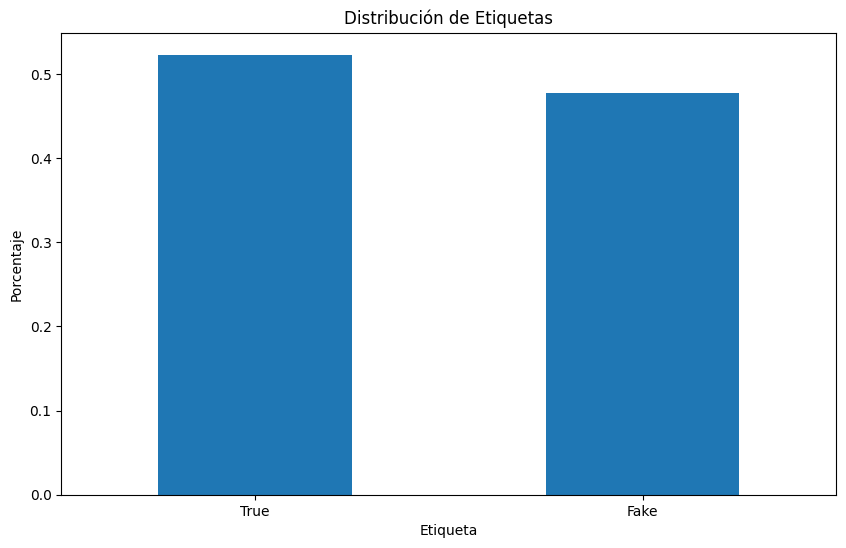

isFake
1    0.522985
0    0.477015
Name: proportion, dtype: float64

In [19]:
# Mostramos la distribución del label
plt.figure(figsize=(10, 6))
df['isFake'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribución de Etiquetas')
plt.xlabel('Etiqueta')
plt.ylabel('Porcentaje')
plt.xticks([0, 1], ['True', 'Fake'], rotation=0)
plt.show()
df['isFake'].value_counts(normalize=True)

El conjunto de datos parece estar bastante equilibrado, con `52.3%` de los datos etiquetados como `verdaderos` y `47.7%` etiquetados como `falsos`.

### Características del texto

A continuación, obtenemos el conteo de las palabras y caracteres de `title` y `text`.

#### Conteo de Palabras y Caracteres

In [20]:
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))
df['text_word_count'] = df['text'].apply(lambda x: len(x.split()))
df['title_char_count'] = df['title'].apply(lambda x: len(x))
df['text_char_count'] = df['text'].apply(lambda x: len(x))

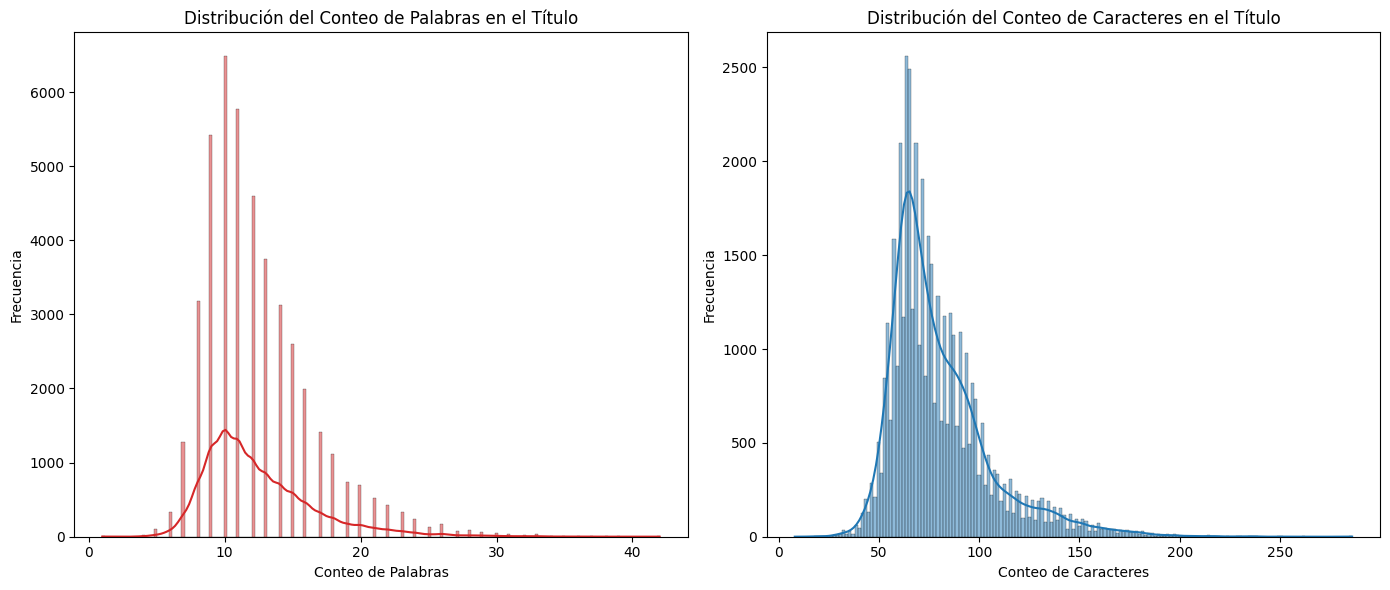

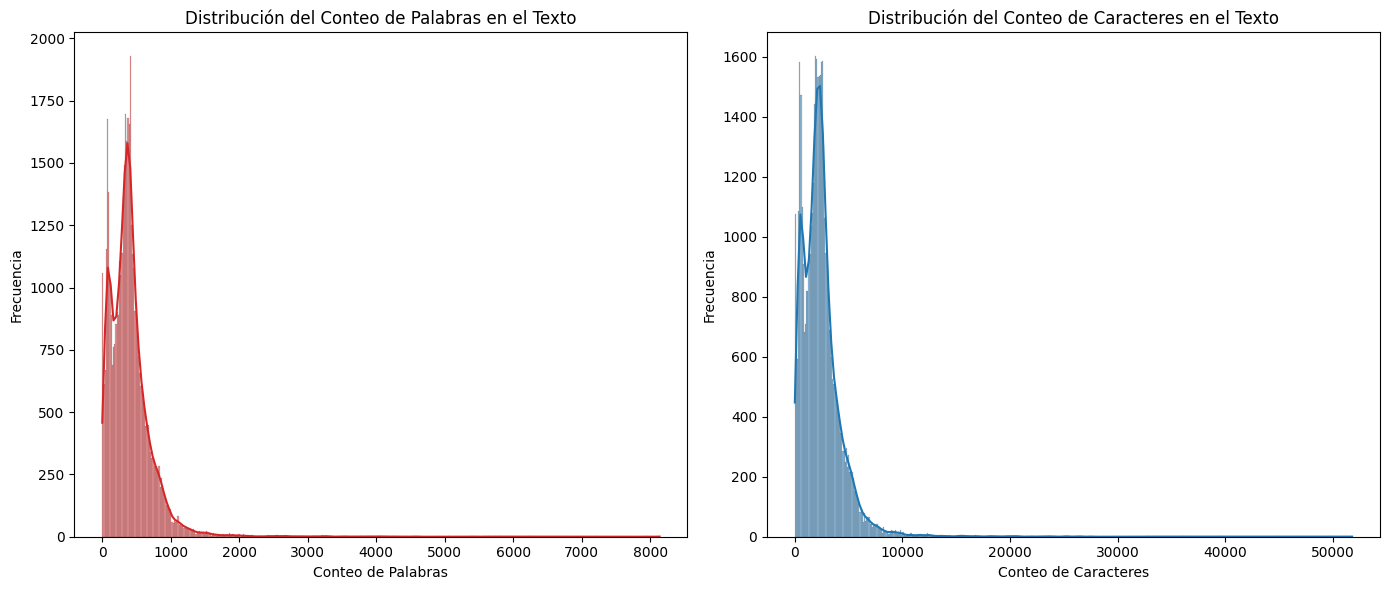

In [21]:
# Graficar la distribución del conteo de palabras en el título
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graficar la distribución del conteo de palabras en el título
sns.histplot(df['title_word_count'], kde=True, ax=ax1, color='tab:red')
ax1.set_title('Distribución del Conteo de Palabras en el Título')
ax1.set_xlabel('Conteo de Palabras')
ax1.set_ylabel('Frecuencia')

# Graficar la distribución del conteo de caracteres en el título
sns.histplot(df['title_char_count'], kde=True, ax=ax2, color='tab:blue')
ax2.set_title('Distribución del Conteo de Caracteres en el Título')
ax2.set_xlabel('Conteo de Caracteres')
ax2.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Graficar la distribución del conteo de palabras en el texto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graficar la distribución del conteo de palabras en el texto
sns.histplot(df['text_word_count'], kde=True, ax=ax1, color='tab:red')
ax1.set_title('Distribución del Conteo de Palabras en el Texto')
ax1.set_xlabel('Conteo de Palabras')
ax1.set_ylabel('Frecuencia')

# Graficar la distribución del conteo de caracteres en el texto
sns.histplot(df['text_char_count'], kde=True, ax=ax2, color='tab:blue')
ax2.set_title('Distribución del Conteo de Caracteres en el Texto')
ax2.set_xlabel('Conteo de Caracteres')
ax2.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

La mayoría de los títulos tienen entre 10 y 15 palabras, con una distribución simétrica y en cuanto los caracteres, suelen oscilar entre los 50 y 100, con una distribución sesgada hacía la derecha. </br>

Respecto al texto, hay una dsitribución asimétrica, donde la mayoría de los artículos tienen entre 300 y 800 palabras, existiendo algunos superando este número, y el número de caracteres, suelen estar entre 1.000 y 10.000. </br>

En conclusión, los títulos presentan una longitud consistente, mientras que los textos varían mucho más en cuanto a su extensión.

##### Palabras únicas
Comprobaremos la riqueza del texto.

In [ ]:
stop = set(stopwords.words('english'))

df['unique_words'] = df['text'].apply(lambda x: len(set(str(x).split())))

# Eliminamos las stopwords y calculamos la proporción de stopwords en el texto
df['stopword_ratio'] = df['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in stop]) / len(str(x).split()) if len(str(x).split()) > 0 else 0)

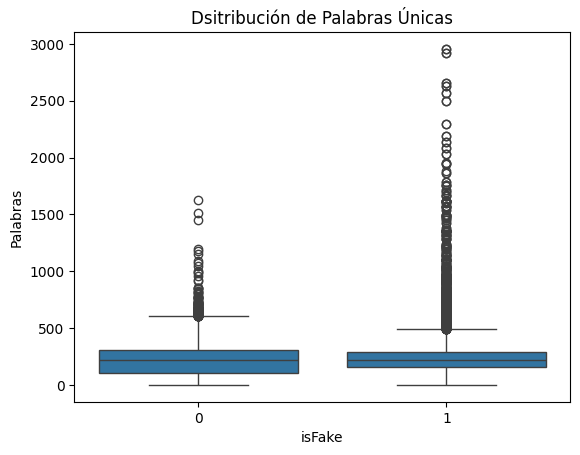

In [23]:
sns.boxplot(data=df, x='isFake', y='unique_words')
plt.title('Dsitribución de Palabras Únicas')
plt.xlabel('isFake')
plt.ylabel('Palabras')
plt.show()

Podemos ver que en ambos casos hay un número similar de palabras únicas, con una mediana entre 200-300 palabras.

A parte, hay valores atípicos (outliers) en las fake news, habiendo casos donde hay más de 2.000 palabras únicas.

### Análisis del tema y fecha

#### Tema
Obtenemos la frecuencia de cada tema respecto la etiqueta.

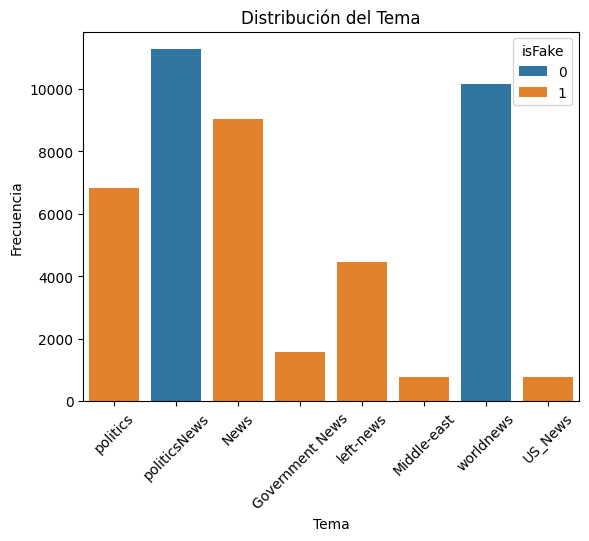

In [24]:
sns.countplot(data=df, x='subject', hue='isFake')
plt.title('Distribución del Tema')
plt.xlabel('Tema')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

Observamos que las noticias verdaderas solo abarcan dos temas, mientras que las falsas cubren una variedad más amplia y, que ambas tratan sobre política.
Además, dado que los temas de ambas clases no se solapan directamente y no parecen tener un impacto significativo en la clasificación, podemos considerar eliminar esta característica del conjunto de datos para simplificar el modelo y evitar posibles ruidos.

#### Fechas
Analizar la distribución temporal de las noticias falsas respecto las verdaderas.

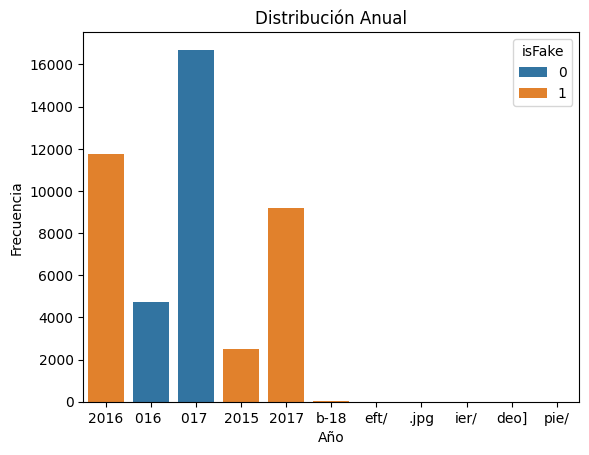

In [25]:
df['year'] = df['date'].astype(str).str[-4:]
sns.countplot(data=df, x='year', hue='isFake')
plt.title('Distribución Anual')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()

Como se puede observar, las noticias se publicaron entre los años 2015 y 2017, un período marcado por eventos relevantes en Estados Unidos, como las elecciones presidenciales de 2016, la creciente polarización política y el auge de la desinformación en redes sociales, factores que pudieron influir en la proliferación de noticias falsas.

### Análisis del texto

#### Palabras comunes
Identificar palabras frecuentes en `title` y `text`, separadas por etiquetas `fake` y `true`.

In [ ]:
# Obtener las stopwords
stop = set(stopwords.words('english'))

# Función para filtrar stopwords y símbolos
def filter_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop and word not in string.punctuation]
    return filtered_words

# Filtrar stopwords y símbolos del texto
fake_words = Counter(filter_words(" ".join(df[df['isFake'] == 1]['text'])))
fake_words = Counter(fake_words).most_common(20)

true_words = Counter(filter_words(" ".join(df[df['isFake'] == 0]['text'])))
true_words = Counter(true_words).most_common(20)

fake_df = pd.DataFrame(fake_words, columns=['word', 'count'])
true_df = pd.DataFrame(true_words, columns=['word', 'count'])

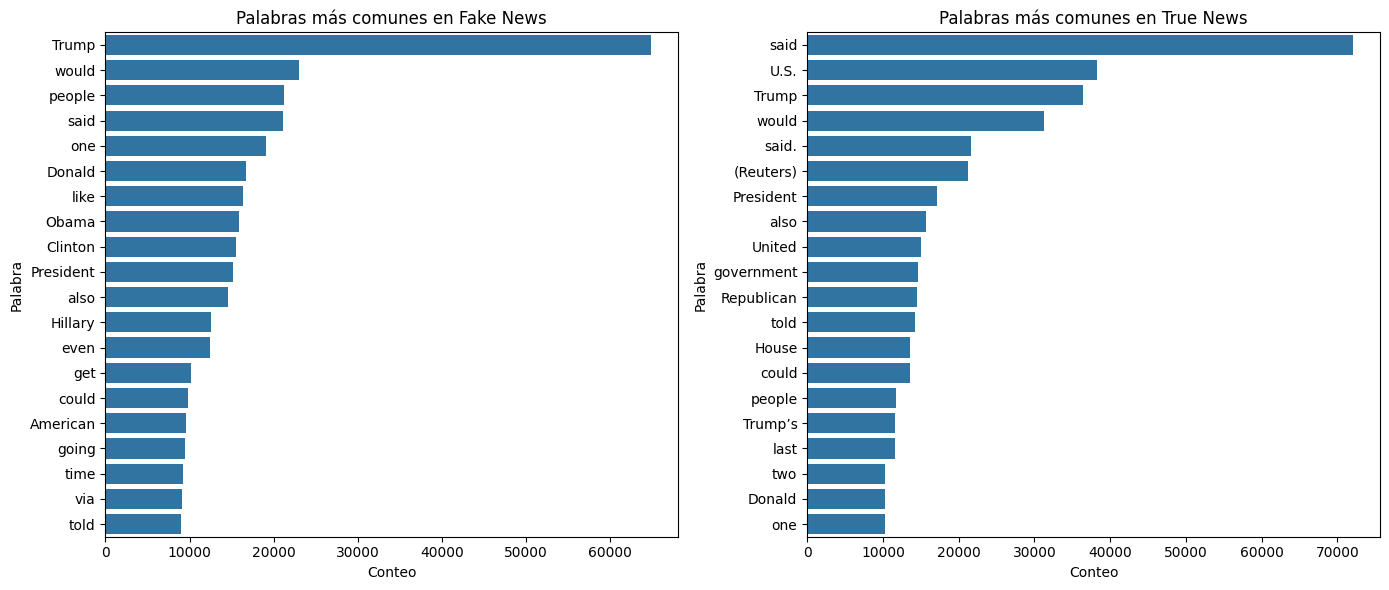

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=fake_df, x='count', y='word', ax=ax1)
ax1.set_title('Palabras más comunes en Fake News')
ax1.set_xlabel('Conteo')
ax1.set_ylabel('Palabra')

sns.barplot(data=true_df, x='count', y='word', ax=ax2)
ax2.set_title('Palabras más comunes en True News')
ax2.set_xlabel('Conteo')
ax2.set_ylabel('Palabra')

plt.tight_layout()
plt.show()

#### N-Gramas
Extraer y visualizar los bigramas más comunes.

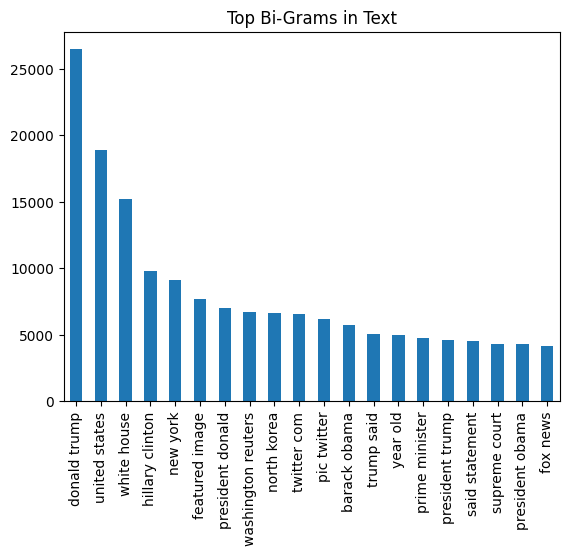

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10000)
ngrams = vectorizer.fit_transform(df['text'])
ngram_counts = pd.DataFrame(ngrams.toarray(), columns=vectorizer.get_feature_names_out())
top_ngrams = ngram_counts.sum().sort_values(ascending=False).head(20)
top_ngrams.plot(kind='bar')
plt.title('Top Bi-Grams in Text')
plt.show()

#### Análisis de Sentimiento
Mediante una libreria, analizar la polaridad de sentimientos de las noticias.

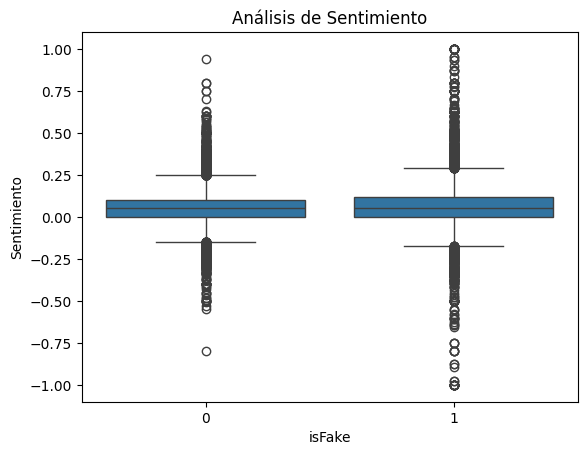

In [ ]:
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.boxplot(data=df, x='isFake', y='sentiment')
plt.title('Análisis de Sentimiento')
plt.ylabel('Sentimiento')
plt.show()

La media del sentimiento general de las noticias se encuentra entre 0 y 0.10, lo que indica que la mayoría de las noticias tienen un sentimiento neutro. Sin embargo, se observa una dispersión significativa de los datos, con una notable cantidad de valores atípicos en ambas clases (noticias verdaderas y falsas). Estos outliers reflejan noticias con un sentimiento marcadamente positivo o negativo, aunque no parece haber una diferencia clara en la distribución general del sentimiento entre ambas categorías, lo que sugiere que el análisis de sentimiento podría no ser un fuerte diferenciador para clasificar las noticias como verdaderas o falsas.

#### Nube de palabras
Generar una nube de palabras para notícias `fake` y `true` para visualizar los términos comunes.

In [ ]:
fake_text = " ".join(df[df['isFake'] == 1]['text'])
true_text = " ".join(df[df['isFake'] == 0]['text'])

fake_wc = WordCloud(width=800, height=800, background_color='white').generate(fake_text)
true_wc = WordCloud(width=800, height=800, background_color='white').generate(true_text)

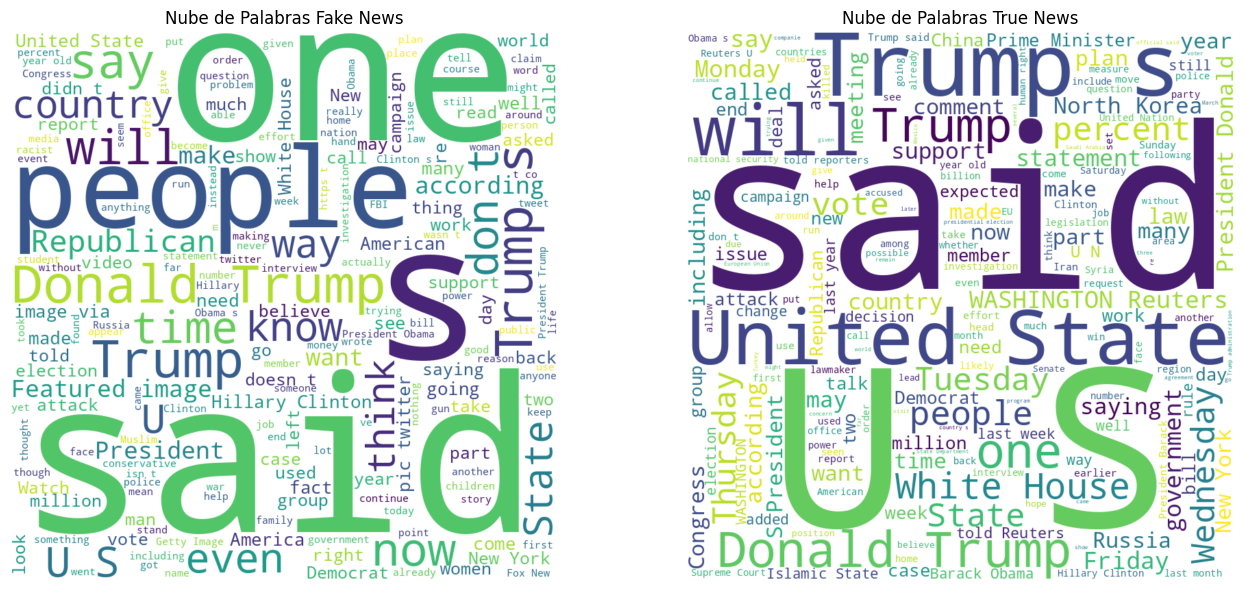

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(fake_wc, interpolation='bilinear')
ax1.set_title('Nube de Palabras Fake News')
ax1.axis('off')

ax2.imshow(true_wc, interpolation='bilinear')
ax2.set_title('Nube de Palabras True News')
ax2.axis('off')
plt.tight_layout()
plt.show()

### Correlación
Obtener correlaciones de las características obtenidas

In [32]:
corr = df[['title_word_count', 'text_word_count', 'unique_words', 'stopword_ratio', 'isFake']].corr()

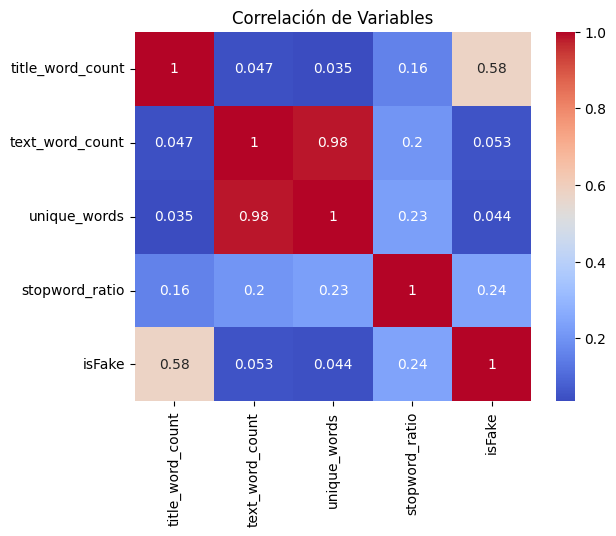

In [33]:
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlación de Variables')
plt.show()

## Preprocessing
Combinaremos el contenido del título y del texto en un solo campo. Eliminaremos los registros duplicados, los textos vacíos y cualquier columna innecesaria para optimizar el proceso y reducir la complejidad.

In [2]:
# Cargar el dataset
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')

# Añadir una columna para indicar si la noticia es falsa o verdadera
df_true['isFake'] = 0
df_fake['isFake'] = 1

# Juntar los dos datasets
df = pd.concat([df_true, df_fake], ignore_index=True)

# Mezclar el dataset
df = df.sample(frac=1).reset_index(drop=True)

# Junta el título y el texto
df['content'] = df['title'] + ' ' + df['text']

# Eliminamos las columnas que no vamos a utilizar
df = df.drop(columns=['title', 'text', 'subject', 'date'])

# Comprobar duplicados
print(f'Duplicated rows: {df.duplicated().sum()}')

# Comprobar Nans, espacios en blanco y cadenas vacías
print('Missing values:')
print(df.isnull().sum())
print('Empty strings:')
print((df == '').sum())

# Eliminamos las filas duplicadas
df = df.drop_duplicates()

# Comprobar duplicados
print('====================')
print(f'Duplicated rows: {df.duplicated().sum()}')

# Comprobar Nans, espacios en blanco y cadenas vacías
print('Missing values:')
print(df.isnull().sum())
print('Empty strings:')
print((df == '').sum())

display(df.head())

Duplicated rows: 5793
Missing values:
isFake     0
content    0
dtype: int64
Empty strings:
isFake     0
content    0
dtype: int64
Duplicated rows: 0
Missing values:
isFake     0
content    0
dtype: int64
Empty strings:
isFake     0
content    0
dtype: int64


,isFake,content
0,0,Britons can change terms of Brexit to diverge ...
1,1,“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Ne...
2,0,Spanish judge orders arrest of ousted Catalan ...
3,1,"Report: After Millions Promised, Trump Gave B..."
4,0,Tunisia parliament approves controversial amne...


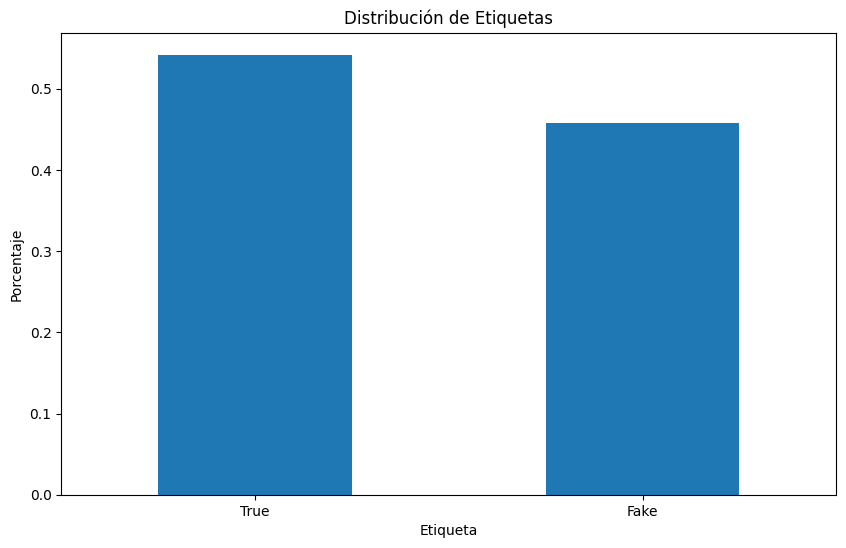

isFake
0    0.542053
1    0.457947
Name: proportion, dtype: float64

In [40]:
# Mostramos la distribución del label
plt.figure(figsize=(10, 6))
df['isFake'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribución de Etiquetas')
plt.xlabel('Etiqueta')
plt.ylabel('Porcentaje')
plt.xticks([0, 1], ['True', 'Fake'], rotation=0)
plt.show()
df['isFake'].value_counts(normalize=True)

Podemos ver que despues de procesar los datos, las clases se han desbalanceado levemente, por lo cual usaremos el F1 score como métrica principal y la confusion matrix para interpretar los resultados.

La siguiente función límpia el texto; eliminando signos de puntuación, stopwords, caracteres especiales y caracteres que no pertenecen al alfabeto.

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def tokenize_text(raw_text):
    # Minimizar todo el texto y eliminar caracteres especiales y espacios en blanco
    raw_text = re.sub(r'[^a-zA-Z\s]', ' ', raw_text.lower())
    
    # Eliminar caracteres de una sola letra y espacios en blanco adicionales
    raw_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', raw_text)
    raw_text = re.sub(r'\s+', ' ', raw_text).strip()

    # Tokenizar el texto
    tokens = word_tokenize(raw_text)

    # Lemmatizar las palabras y filtrar stopwords y palabras cortas
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]

    return tokens

def clean_text(raw_text):
    # Minimizar todo el texto y eliminar caracteres especiales y espacios en blanco
    raw_text = re.sub(r'[^a-zA-Z\s]', ' ', raw_text.lower())
    
    # Eliminar caracteres de una sola letra y espacios en blanco adicionales
    raw_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', raw_text)
    raw_text = re.sub(r'\s+', ' ', raw_text).strip()

    # Tokenizar el texto
    tokens = word_tokenize(raw_text)

    # Lemmatizar las palabras y filtrar stopwords y palabras cortas
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]

    indices = np.unique(tokens, return_index=True)[1]
    cleaned_text = np.array(tokens)[np.sort(indices)].tolist()

    return cleaned_text

def plot_confusion_mat(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Separaremos el dataset en los conjuntos train y test, y, utilizaremos TfidfVectorizer para convertir el texto en vectores de características numéricas.

In [4]:
# Inicializar el vectorizador
vectorizer = TfidfVectorizer(
    max_features=10000, # limitar la dimensionalidad
    ngram_range=(1, 2), # considerar unigramas y bigramas
    min_df=5, 
    max_df=0.7, 
    use_idf=True, 
    sublinear_tf=True, 
    norm='l2',
    token_pattern=None,
    tokenizer=tokenize_text
)

X = df['content']
y = df['isFake']

In [4]:
# Guardar el vectorizador
vectorizer.fit(X)
joblib.dump(vectorizer, 'data/vectorizer.pkl')

['data/vectorizer.pkl']

In [5]:
# Cargamos el vectorizador
vectorizer = joblib.load('data/vectorizer.pkl')

# Dividir el dataset en entrenamiento 80% y prueba 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Model selection
Probaremos varios modelos:
<ul>
    <li>Naive Bayes</li>
    <li>Logistic Regression</li>
    <li>Random Forest</li>
    <li>LSTM</li>
</ul>

### Naive Bayes

Mean F1 Score: 0.9495873466337365
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4223
           1       0.95      0.95      0.95      3598

    accuracy                           0.95      7821
   macro avg       0.95      0.95      0.95      7821
weighted avg       0.95      0.95      0.95      7821



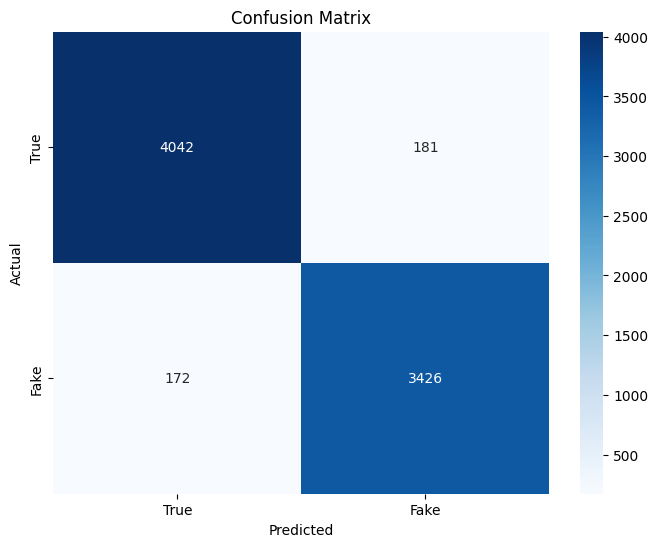

In [9]:
# Inicializar el modelo
model = MultinomialNB()

# Aplicar validación cruzada con 15 folds
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=15, scoring='f1')

# Mostrar los resultados
print(f'Mean F1 Score: {cv_scores.mean()}')

# Entrenar el modelo
model.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_tfidf)

# Evaluar el modelo
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_confusion_mat(confusion_matrix(y_test, y_pred))

### Logistic Regression

Mean F1 Score: 0.9873504096027009
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4223
           1       1.00      0.98      0.99      3598

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



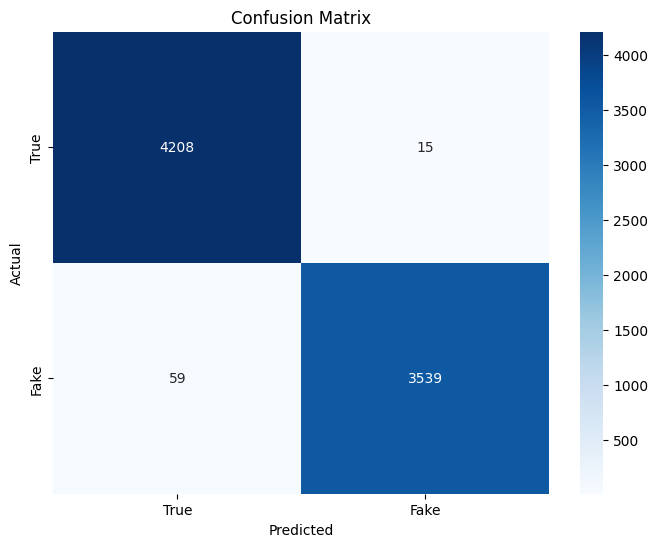

In [10]:
# Inicializar el modelo
model = LogisticRegression()

# Aplicar validación cruzada con 15 folds
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=15, scoring='f1')

# Mostrar los resultados
print(f'Mean F1 Score: {cv_scores.mean()}')

# Entrenar el modelo
model.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_tfidf)

# Evaluar el modelo
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_confusion_mat(confusion_matrix(y_test, y_pred))

### Random Forest

In [20]:
# Inicializar el modelo
model = RandomForestClassifier()

# Aplicar validación cruzada con 15 folds
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=15, scoring='f1')

# Mostrar los resultados
print(f'Mean F1 Score: {cv_scores.mean()}')

# Entrenar el modelo
model.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_tfidf)

# Evaluar el modelo
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_confusion_mat(confusion_matrix(y_test, y_pred))

KeyboardInterrupt: 

### LSTM
Para poder entrenar el modelo de deep learning, tenemos que procesar el texto antes de entrenarlo.

In [11]:
# Procesar el texto
news = list(df['content'])
cleaned_news = [clean_text(text) for text in news]
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(cleaned_news, y, test_size=0.2, random_state=42)

# Tokenizar el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_dl)
vocabulary = len(tokenizer.word_index) + 1

# Convertir el texto a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train_dl)
X_test_seq = tokenizer.texts_to_sequences(X_test_dl)

# Añadir padding a las secuencias para asegurar que todas tengan la misma longitud
max_lenght = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_lenght)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_lenght)

In [ ]:
# Definimos el modelo
_input = Input(shape=(max_lenght,))     # Definimos la capa de entrada con la longitud máxima de las secuencias

x = Embedding(vocabulary, 100)(_input)  # Añadimos una capa de embedding con el tamaño del vocabulario y dimensión de salida de 100
x = Dropout(0.5)(x)                     # Añadimos una capa de dropout con una tasa de 0.5 para evitar el sobreajuste
x = LSTM(150, return_sequences=True)(x) # Añadimos una capa LSTM con 150 unidades y return_sequences=True para devolver la secuencia completa
x = Dropout(0.5)(x)                     # Añadimos otra capa de dropout con una tasa de 0.5
x = GlobalMaxPool1D()(x)                # Añadimos una capa de pooling global para reducir la dimensionalidad
x = Dense(64, activation='relu')(x)     # Añadimos una capa densa con 64 unidades y función de activación ReLU
x = Dropout(0.5)(x)                     # Añadimos otra capa de dropout con una tasa de 0.5
x = Dense(2, activation='softmax')(x)   # Añadimos la capa de salida con 2 unidades y función de activación softmax para clasificación binaria

model = Model(_input, x)

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

2024-12-05 17:56:40.267887: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Como usamos categorical_crossentropy, necesitamos codificar las etiquetas en one-hot
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_dl)
y_test_encoded = label_encoder.transform(y_test_dl)
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

In [ ]:
# Entrenamos el modelo
history = model.fit(X_train_pad, y_train_onehot, epochs=15, validation_data=(X_test_pad, y_test_onehot))

# Guardamos el modelo
model.save('models/lstm.keras')

Epoch 1/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 225s 228ms/step - accuracy: 0.8491 - loss: 0.2658 - val_accuracy: 0.9887 - val_loss: 0.0472
Epoch 2/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 224s 229ms/step - accuracy: 0.9934 - loss: 0.0219 - val_accuracy: 0.9886 - val_loss: 0.0371
Epoch 3/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 223s 228ms/step - accuracy: 0.9985 - loss: 0.0052 - val_accuracy: 0.9873 - val_loss: 0.0404
Epoch 4/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 224s 229ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 0.9891 - val_loss: 0.0394
Epoch 5/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 223s 228ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9885 - val_loss: 0.0409
Epoch 6/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 224s 229ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9870 - val_loss: 0.0405
Epoch 7/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 223s 228ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9863 - val_loss: 0.0390
Epoch 8/15
978/978 ━━━━━━━━━━━━━━━━━━━━ 223s 228ms/step - accuracy: 0.9992 -

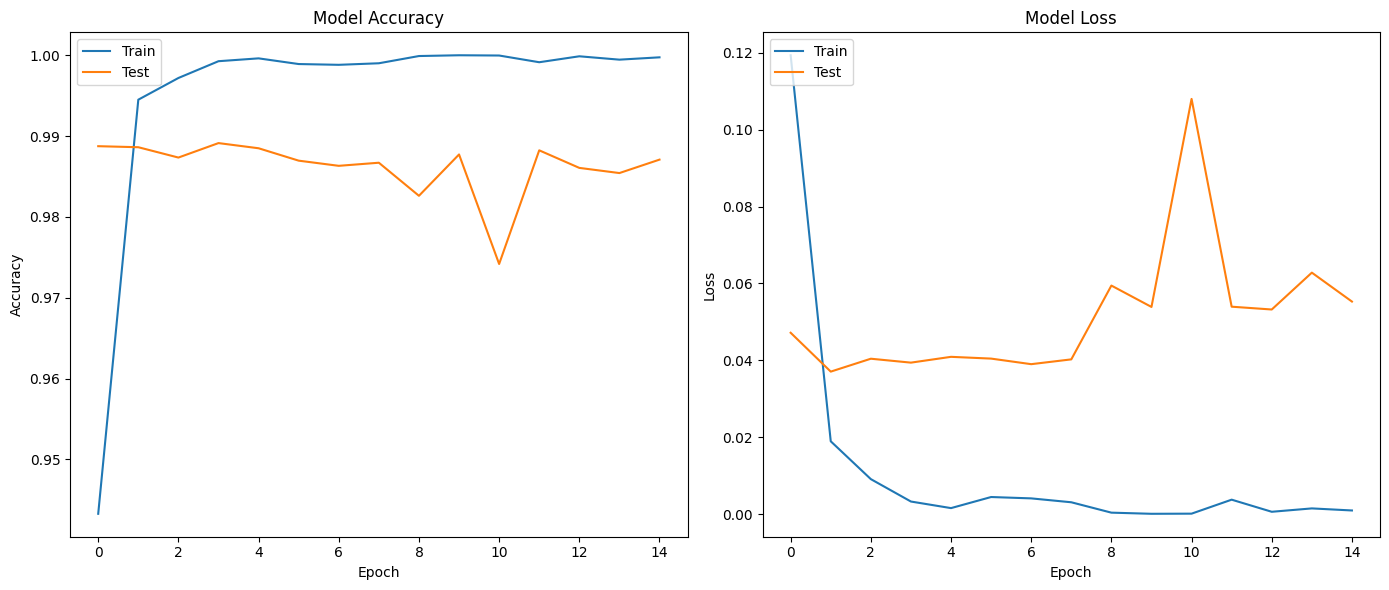

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mostrar la precisión del modelo en el conjunto de entrenamiento y prueba
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Test'], loc='upper left')

# Mostrar la pérdida del modelo en el conjunto de entrenamiento y prueba
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9842 - loss: 0.0581
Loss: 0.055295180529356
Accuracy: 0.9870860576629639
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step


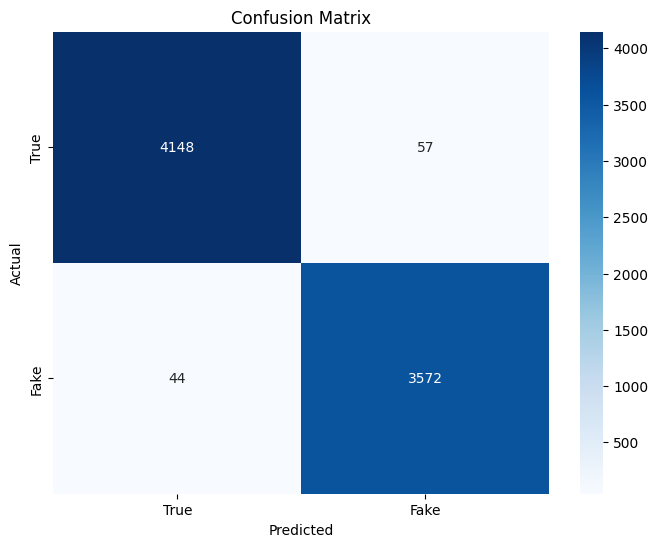

In [23]:
# Evaluamos el modelo con el conjunto de prueba
loss, accuracy = model.evaluate(X_test_pad, y_test_onehot)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Matriz de confusión
y_pred_probs = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_onehot, axis=1)
plot_confusion_mat(confusion_matrix(y_true_labels, y_pred_labels))

### RoBERTa

Prepararemos el dataset, tokenizandolo y luego convertirlo en formato Hugging Face Dataset para poder passarlo al modelo.

In [3]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['content'], df['isFake'], test_size=0.2, random_state=42)

# Cargar RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_data(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=512, return_tensors='pt')

# Tokenizar los datos
train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

# Crear los datasets siguiendo el formato Hugging Face
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings['input_ids'],
    "attention_mask": train_encodings['attention_mask'],
    "labels": torch.tensor(train_labels.tolist())
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings['input_ids'],
    "attention_mask": test_encodings['attention_mask'],
    "labels": torch.tensor(test_labels.tolist())
})

In [ ]:
# Cargar el modelo pre-entrenado
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./models/roberta/results',      # Directorio de salida
    eval_strategy='epoch',                # Evalua el model al final de cada epoch
    per_device_train_batch_size=8,              # Tamaño del batch de entrenamiento
    per_device_eval_batch_size=8,               # Tamaño del batch de evaluación
    num_train_epochs=5,                        # Número de epochs
    weight_decay=0.01,                          # Fuerza de regularización
    logging_dir='./models/roberta/logs',        # Directorio de logs
    logging_steps=10,                           # Cada cuantos pasos se guardan los logs
    save_total_limit=1,                         # Número máximo de checkpoints a guardar
)

# Inicializar el Trainer
trainer = Trainer(
    model=model,                         # Modelo a entrenar
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=train_dataset,         # Dataset de entrenamiento
    eval_dataset=test_dataset            # Dataset de evaluación
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Entrenar el modelo
trainer.train()

  0%|          | 9/58665 [02:52<311:42:10, 19.13s/it]


KeyboardInterrupt: 